In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras.utils import plot_model

import datetime
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile

2024-05-16 09:41:37.418137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 09:41:37.418200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 09:41:37.419705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/final-stage-3-v3/Stage 3 V3'

In [3]:
def resize_with_padding(img):
    w, h = img.shape[1], img.shape[0]
    if h > w:
        new_h = 299
        new_w = int(w * (299 / h))
    else:
        new_w = 299
        new_h = int(h * (299 / w))
    
    img = tf.image.resize(img, [new_h, new_w])
    img = tf.image.resize_with_pad(img, 299, 299)
    
    return img

In [4]:
temp_dir = tempfile.mkdtemp()

class_names = os.listdir(dataset_path)

os.makedirs(temp_dir + '/train')
os.makedirs(temp_dir + '/val')
os.makedirs(temp_dir + '/test')

for class_name in class_names:
    os.makedirs(temp_dir + '/train/' + class_name)
    os.makedirs(temp_dir + '/val/' + class_name)
    os.makedirs(temp_dir + '/test/' + class_name)
    
    image_names = os.listdir(dataset_path + '/' + class_name)
    np.random.shuffle(image_names)
    
    train_names = image_names[:int(len(image_names)*0.8)]
    val_names = image_names[int(len(image_names)*0.8):int(len(image_names)*0.9)]
    test_names = image_names[int(len(image_names)*0.9):]

    for name in train_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/train/' + class_name + '/' + name)
    for name in val_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/val/' + class_name + '/' + name)
    for name in test_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/test/' + class_name + '/' + name)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=resize_with_padding
)

train_generator = datagen.flow_from_directory(
    temp_dir + '/train',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    temp_dir + '/val',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    temp_dir + '/test',
    target_size=(299, 299),
    batch_size=16,
    class_mode='binary'
)

Found 1292 images belonging to 2 classes.
Found 162 images belonging to 2 classes.
Found 163 images belonging to 2 classes.


In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # InceptionV3 expects input size of (299, 299)

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())

model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * 0.95)

lr_scheduler = LearningRateScheduler(lr_schedule)

optimizer = optimizers.Adam(learning_rate=0.0001)

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])

model.build(input_shape=(None, 299, 299, 3))

log_dir = "/kaggle/working/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

In [6]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystop, tensorboard_callback, lr_scheduler])

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715852609.581970    1289 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.6899 - loss: 0.5649
Epoch 1: val_loss improved from inf to 0.34150, saving model to best_model.keras


W0000 00:00:1715852703.351976    1289 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


81/81 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.6911 - loss: 0.5635 - val_accuracy: 0.8580 - val_loss: 0.3415 - learning_rate: 1.0000e-04
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8966 - loss: 0.2449
Epoch 2: val_loss improved from 0.34150 to 0.22110, saving model to best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 717ms/step - accuracy: 0.8968 - loss: 0.2449 - val_accuracy: 0.8951 - val_loss: 0.2211 - learning_rate: 1.0000e-04
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9284 - loss: 0.1779
Epoch 3: val_loss did not improve from 0.22110
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 652ms/step - accuracy: 0.9284 - loss: 0.1781 - val_accuracy: 0.8889 - val_loss: 0.2467 - learning_rate: 1.0000e-04
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9474 - loss: 0.1312
Epoch 4: val_loss improved from 0.22110 to 0.20275, saving model to best_model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 717ms/step - accuracy: 0.9475 - loss: 0.1312 - val_accu

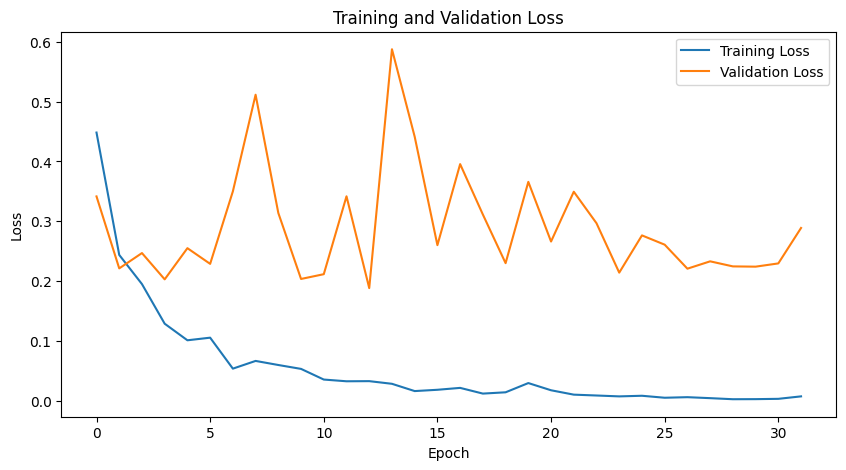

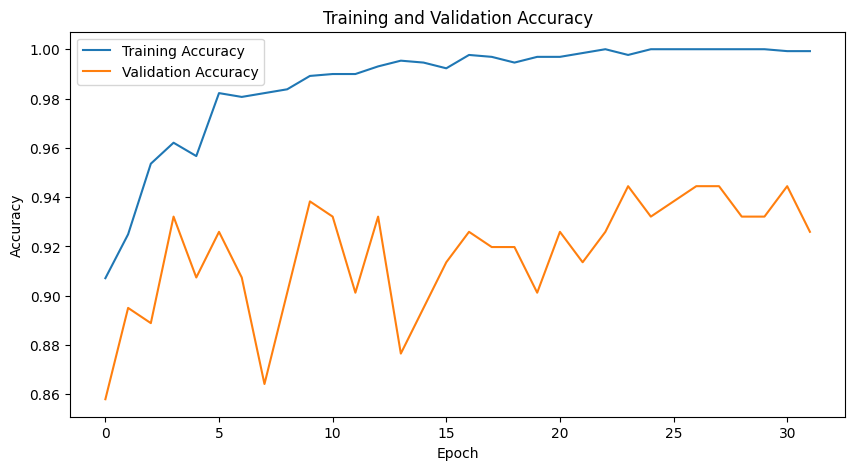

In [7]:
max_loss_threshold = 2.0
min_accuracy_threshold = 0.8

filtered_train_loss = [v for v in history.history['loss'] if v <= max_loss_threshold]
filtered_val_loss = [v for v in history.history['val_loss'] if v <= max_loss_threshold]

filtered_train_accuracy = [v for v in history.history['accuracy'] if v >= min_accuracy_threshold]
filtered_val_accuracy = [v for v in history.history['val_accuracy'] if v >= min_accuracy_threshold]

min_len = min(len(filtered_train_loss), len(filtered_val_loss), len(filtered_train_accuracy), len(filtered_val_accuracy))
filtered_train_loss = filtered_train_loss[:min_len]
filtered_val_loss = filtered_val_loss[:min_len]
filtered_train_accuracy = filtered_train_accuracy[:min_len]
filtered_val_accuracy = filtered_val_accuracy[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_loss, label='Training Loss')
plt.plot(filtered_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_accuracy, label='Training Accuracy')
plt.plot(filtered_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [8]:
model.load_weights('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 943ms/step - accuracy: 0.9129 - loss: 0.2652
Test Loss: 0.2432, Test Accuracy: 0.91%


W0000 00:00:1715854516.038630    1289 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
